In [1]:
# !pip install drake

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pydot
from IPython.display import SVG, display, HTML
from pydrake.all import (
    DiagramBuilder,
    DirectCollocation,
    DiscreteTimeApproximation,
    ExtendedKalmanFilter,
    ExtendedKalmanFilterOptions,
    FiniteHorizonLinearQuadraticRegulatorOptions,
    MakeFiniteHorizonLinearQuadraticRegulator,
    PiecewisePolynomial,
    PlanarSceneGraphVisualizer,
    Simulator,
    Solve,
    UnscentedKalmanFilter,
    UnscentedKalmanFilterOptions,
    VectorLogSink,
    ZeroOrderHold,
)

# import requests
# r = requests.get("https://raw.githubusercontent.com/wei-chen-li/wei-chen-li.github.io/main/content/post/triple-pendulum-swingup/notebooks/utils.py")
# exec(r.text)
from utils import CartMultiPendulumSystem

#### Helper functions

In [3]:
def JointState2WorldState(arg1):
    if isinstance(arg1, (int, float)):
        num_states = arg1
    else:
        state = np.array(arg1)
        num_states = len(state)

    assert(num_states % 2 == 0)
    num_pendulums = num_states // 2 - 1
    T = np.block([[np.array([1]), np.zeros((1,num_pendulums))],
                  [np.zeros((num_pendulums,1)), np.tri(num_pendulums)]])
    T = np.block([[T, np.zeros(T.shape)],
                  [np.zeros(T.shape), T]])

    return T if isinstance(arg1, (int, float)) else T.dot(state)

def WorldState2JointState(arg1):
    if isinstance(arg1, (int, float)):
        return np.linalg.inv(JointState2WorldState(arg1))
    else:
        state = np.array(arg1)
        T = JointState2WorldState(len(state))
        return np.linalg.inv(T).dot(state)

### Trajectory optimization

In [4]:
plant = CartMultiPendulumSystem(m_cart=1, m1=1,l1=1, m2=1,l2=1)
num_pendulums = plant.num_pendulums

dircol = DirectCollocation(
    plant,
    plant.CreateDefaultContext(),
    num_time_samples=30,
    minimum_time_step=0.01,
    maximum_time_step=0.1
)
prog = dircol.prog()

x_start = WorldState2JointState([0] * (2 * num_pendulums + 2))
prog.AddBoundingBoxConstraint(x_start, x_start, dircol.initial_state())

x_target = WorldState2JointState([0] + [np.pi] * num_pendulums + [0] * (num_pendulums + 1))
prog.AddBoundingBoxConstraint(x_target, x_target, dircol.final_state())

dircol.AddRunningCost(10 * dircol.input()[0] ** 2)

u_trj_init = PiecewisePolynomial()
x_trj_init = PiecewisePolynomial.FirstOrderHold([0.0, 4.0], np.vstack([x_start, x_target]).T)
dircol.SetInitialTrajectory(u_trj_init, x_trj_init)

result = Solve(prog)
print("Found trajectory? ", result.is_success())

x_trj = dircol.ReconstructStateTrajectory(result)
u_trj = dircol.ReconstructInputTrajectory(result)

Found trajectory?  True


### Trajectory tracking

In [5]:
Q = np.diag([10] * (num_pendulums+1) + [1] * (num_pendulums+1))
R = np.diag([1])

time_period = 0.01
t = np.arange(x_trj.start_time(), x_trj.end_time(), time_period)

options = FiniteHorizonLinearQuadraticRegulatorOptions()
options.Qf = Q
options.x0 = x_trj
options.u0 = u_trj

discretized_plant = DiscreteTimeApproximation(plant, time_period)

controller = MakeFiniteHorizonLinearQuadraticRegulator(
    system=discretized_plant,
    context=discretized_plant.CreateDefaultContext(),
    t0=t[0],
    tf=t[-1],
    Q=Q,
    R=R,
    options=options
)
controller.set_name("swingup_controller")

In [6]:
W = np.diag([10] * (num_pendulums+1) + [1] * (num_pendulums+1)) * 1e-4
V = np.diag([1] * (num_pendulums+1)) * 1e-4

options = UnscentedKalmanFilterOptions()
options.measurement_output_port_index = plant.get_output_port(1).get_index()
options.discrete_measurement_time_period = time_period
options.unscented_transform_parameters = UnscentedKalmanFilterOptions.UnscentedTransformParameters(
    alpha=0.1, beta=2, kappa=0)

observer = UnscentedKalmanFilter(
    observed_system=plant,
    observed_system_context=plant.CreateDefaultContext(),
    W=W,
    V=V,
    options=options)

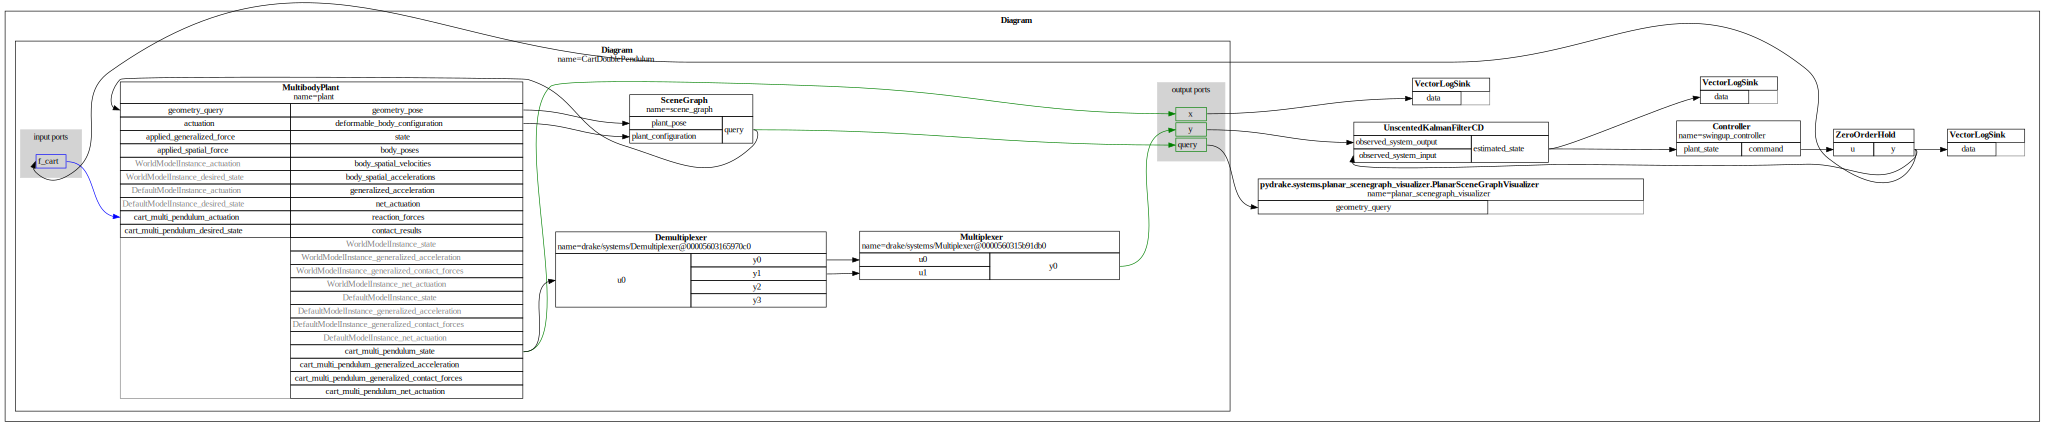

In [7]:
builder = DiagramBuilder()

plant = builder.AddSystem(plant.Clone())

builder.AddSystem(observer)
builder.Connect(plant.get_output_port(1),
                observer.get_observed_system_output_input_port())

controller = builder.AddSystem(controller.Clone())
builder.Connect(observer.get_estimated_state_output_port(),
                controller.get_input_port())

zoh = builder.AddSystem(ZeroOrderHold(time_period, 1))
builder.Connect(controller.get_output_port(), zoh.get_input_port())
builder.Connect(zoh.get_output_port(), plant.get_input_port())
builder.Connect(zoh.get_output_port(),
                observer.get_observed_system_input_input_port())

visualizer = PlanarSceneGraphVisualizer(
    plant.GetSubsystemByName("scene_graph"), show=False)
builder.AddSystem(visualizer)
builder.Connect(plant.GetOutputPort('query'),
                visualizer.get_geometry_query_input_port())

logger_x = builder.AddSystem(VectorLogSink(2 * num_pendulums + 2))
builder.Connect(plant.get_output_port(0),
                logger_x.get_input_port())

logger_x_est = builder.AddSystem(VectorLogSink(2 * num_pendulums + 2))
builder.Connect(observer.get_output_port(0),
                logger_x_est.get_input_port())

logger_u = builder.AddSystem(VectorLogSink(1))
builder.Connect(zoh.get_output_port(), logger_u.get_input_port())

diagram = builder.Build()

display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))

In [8]:
simulator = Simulator(diagram)
simulator.Initialize()
context = simulator.get_context()

visualizer.reset_recording()
visualizer.start_recording()
simulator.AdvanceTo(t[-1])
visualizer.stop_recording()

In [9]:
visualizer.fig.set_size_inches([6, num_pendulums*2.1])
visualizer.ax.set_title('t = ?')
visualizer.fig.tight_layout()
visualizer.ax.set_xlim([-3, 3])
bbox = visualizer.ax.get_position()
bbox.x0, bbox.x1 = 0, 1
visualizer.ax.set_position(bbox)

HTML(visualizer.get_recording_as_animation().to_jshtml())

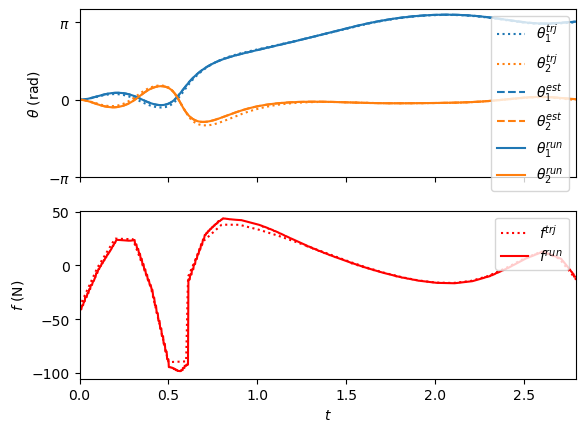

In [10]:
fig = plt.figure()
ax1, ax2 = fig.subplots(2, 1, sharex=True)

trj_t = np.linspace(x_trj.start_time(), x_trj.end_time(), 1000)
ax1.plot(trj_t, (x_trj.vector_values(trj_t).T)[:,1:num_pendulums+1], ':')
ax1.set_prop_cycle(None)
sim_t = logger_x_est.FindLog(context).sample_times()
ax1.plot(sim_t, (logger_x_est.FindLog(context).data().T)[:,1:num_pendulums+1], '--')
ax1.set_prop_cycle(None)
sim_t = logger_x.FindLog(context).sample_times()
ax1.plot(sim_t, (logger_x.FindLog(context).data().T)[:,1:num_pendulums+1], '-')
ax1.legend([rf'$\theta_{i}^{{trj}}$' for i in range(1,num_pendulums+1)] +
           [rf'$\theta_{i}^{{est}}$' for i in range(1,num_pendulums+1)] +
           [rf'$\theta_{i}^{{run}}$' for i in range(1,num_pendulums+1)], loc='upper right')
ax1.set_ylabel(r'$\theta$ (rad)')
ax1.set_yticks([-np.pi, 0, np.pi])
ax1.set_yticklabels([r'$-\pi$', '$0$', '$\pi$'])

ax2.plot(trj_t, u_trj.vector_values(trj_t).T, 'r:')
ax2.plot(sim_t, logger_u.FindLog(context).data().T, 'r-')
ax2.legend(['$f^{trj}$'] + ['$f^{run}$'], loc='upper right')
ax2.set_ylabel('$f$ (N)')
ax2.set_xlabel('$t$')
ax2.set_xlim(min(sim_t), max(sim_t))

plt.show()